# Timescales 

We would like to find and plot the relevant timescales for our binary as a function of separation. The main stages of our binary's evolution are: (1) dynamical friction, (2) stellar hardening, and (3) GW emission. We will also include the timescales for gas infall. Below we give the relevant equations for all of these processes. Note that this notebook is based off of Chiara Mingarelli's "Binary_Residence_Time.ipynb" notebook in her [nanohertz_GWs](https://github.com/ChiaraMingarelli/nanohertz_GWs) repository.

 The dynamical friction timescale is (Binney & Tremaine [BT] Eq. 8.12):
 
\begin{equation}
    t_{\rm{dyn}} = \frac{19\ \rm{Gyr}}{\ln \Lambda} \left( \frac{a}{5\ \rm{kpc}}\right)^2 \frac{\sigma}{200\ \rm{km/s}} \frac{10^8\ M_{\odot}}{M_2} \; , 
\end{equation}

where $a$ is the current semi-major axis of the binary, $\sigma$ is the velocity dispersion of the stars, and $M_2$ is the mass of the lighter black hole. The final part of the equation is the Coulomb logarithm, which is given by (BT Eq. 8.1b):

\begin{equation}
    \Lambda \approx \frac{a\sigma^2}{GM_1} \; ,
\end{equation}

Dynamical friction will remain dominant until the pair become a hard binary, which occurs when $v_{\rm{binary}} > v_{\rm{stars}}$ (where these are both circular velocities). 

After this point, the binary should experience orbital decay due to 3-body interactions (otherwise referred to as stellar hardening). The timescale for this to occur is highly dependent on the stellar profile. We will follow previously used procedures (see Sesana & Khan 2015, Mingarelli+ 2017). The timescale is given as:

\begin{equation}
    t_{\rm{hard}} = \frac{\sigma_{\rm{inf}}}{G H \rho_{\rm{inf}} a_{\star/\rm{gw}}}\; ,
\end{equation}

where $\sigma_{\rm{inf}}$ is the velocity dispersion at the BH influence radius, $\rho_{\rm{inf}}$ is the density at the BH influence radius, $H = 15$ is the dimensionless hardening rate constant, and $a_{\star/\rm{gw}}$ is the separation at which GW emission takes over (see Sesana & Khan 2015 for all of these equations). In this notebook, we also include the BT equations for this process in this notebook, just as an extra check.


Since our AGN are both accreting, we will assume that gas infall can also play a role in shrinking the orbit. This timescale is given as (Begelman 1980, Eq. 5):

$$t_{\rm{gas}} \sim \frac{M_{1}}{M_{\odot}} \left(\frac{\dot{M}}{1~M_{\odot}/\rm{yr}}\right)^{-1}~\rm{yr}$$

Finally, we expect our SMBH pair to go through the GW emission phase with a timescale of (BT Eq. 8.23):

\begin{equation}
    t_{\rm{gw}} = 5.81~\rm{Myr} \left( \frac{a}{0.01~\rm{pc}}\right)^4 \left( \frac{10^8~M_{\odot}}{M_1+M_2}\right)^3 \frac{(M_1+M_2)^2}{M_1M_2} \; . 
\end{equation}

Below, we solve for all of these timescales, along with a few other quantities of interest.

In [1]:
## Import necessary packages
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns
import matplotlib.pyplot as plt

## Set plot parameters
%matplotlib inline
sns.set_context("paper",font_scale=1.5)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
prange = lambda _: print('min:', np.min(_), 'max:', np.max(_))
pshape = lambda _: print(np.shape(_))

In [2]:
### measured params
mbh = 4.e8*u.Msun
mtot_bh = 8.e8*u.Msun
z = 0.198
sep = 430*u.pc
a = sep/2. ## semi-major axis assuming circular orbit w/ equal masses.
mstartot = 1.e11*u.Msun ##total stellar mass; actually ranges from 0.7-1.5e11
lbol = 5.e46*u.erg/u.s ## bolometric luminosity of each AGN. This is measured from the [OIII] line flux.

### extra params
gamma = 1. ## Hernquist profile


### GW observation params -- max and min obs. freqs.
lisa_min = 0.1*u.Hz
lisa_max = 1.e-4*u.Hz
pta_min = 1.e-9*u.Hz
pta_max = 1.e-7*u.Hz

In [3]:
### Dynamics Functions
def coulomb_log(a_, sigma_, M1_):
    '''
    Find the Coulomb Logarithm given binary separation,
    stellar vel. disp. and the mass of the larger BH.
    Computed according to Binney & Tremaine (BT) equation 8.1b 
    using binary semi-major axis instead of bmax,
    as mentioned on BT page 652.
    '''
    return np.log10((a_*sigma_**2/(const.G*M1_)).to(''))
def vel_disp(mstar_, r_):
    """
    Find the expected stellar velocity dispersion
    using virial theorem
    """
    return (np.sqrt(const.G*mstar_/r_)).to(u.km/u.s)
def vel_disp_zahid(Mstar_):
    '''
    find velocity dispersion using Faber-Jackson
    from Zahid+ 2016, Eq. 5, Table 1 fits.
    assume log(Mb)>10.3 Msun; use SDSS values
    '''
    logsigmab = 2.2969 #\pm 0.0006; in km/s
    alpha2 = 0.299 #\pm 0.001
    logAns = logsigmab + alpha2*np.log10(Mstar_/(1.e11*u.Msun))
    return (10**logAns)*u.km/u.s
def vel_disp_kormendyho(Mbh_tot_):
    '''
    find velocity dispersion in the bulge given
    Kormendy \& Ho (2013) Eq.7
    '''
    mterm = Mbh_tot_/(1.e9*u.Msun)
    return (mterm/0.310)**(1./4.38)*200*u.km/u.s
def find_mbulge(Mbh_tot_):
    '''
    find mbulge from mbh
    Kormendy \& Ho (2013) Eq. 10
    '''
    mterm = Mbh_tot_/(1.e9*u.Msun)
    return (mterm/0.49)**(1./1.17)*1.e11*u.Msun
def find_reff(Mstar_):
    '''
    Find effective radius for galaxy given mstar.
    Uses Eq. 4 of Dabringhausen, Hilker \& Kroupa (2008)
    note: although this paper talks mostly about dwarfs,
    they do find that this particular equation fits
    massive ellipticals with M\gtrsim 10^11 Msun well.
    '''
    a = 2.95 
    b = 0.596
    return (a*(Mstar_/(1.e6*u.Msun))**b)*u.pc
def orbital_vel(m1_, m2_, a_):
    '''
    gives Keplerian orbital velocity
    assumes circular orbit
    '''
    return (np.sqrt(const.G*(m1_+m2_)/a_)).to(u.km/u.s)
def find_sep_given_vc(m1_,m2_,vc):
    '''
    gives binary separation where 
    orbital vel = vc
    assumes circular orbit
    '''
    return (2*const.G*(m1_+m2_)/vc**2).to(u.pc)
def dyn_timescale(m_, sigma_, a_, coulomb_log_):
    """"
    Finds the dynamical timescale.
    Computed according to equation 8.12 in B&T
    m_ is the secondary BH
    sigma_ is the vel disp of the stars in the core
    a_ is the initial semimajor axis
    """
    prefactor = 19./coulomb_log_
    aterm = (a_/(5.*u.kpc))**2
    vterm = sigma_/(200*u.km/u.s)
    mterm = (10**8*u.Msun/m_)
    return (prefactor*aterm*vterm*mterm*u.Gyr).to(u.Myr)
def find_dyn_hard_radius(m1_,m2_, mstar_, reff_):
    '''
    finds when stellar hardening takes over from
    dynamical friction
    uses Begelman+ (1980) Eq. in paragraph above Eq. 2
    should use rcore and mstar in core instead of reff
    and total mstar....that's why we don't actually use this.
    '''
    rb = (m1_/mstar_)**(1./3.)*reff_
    print("Binary radius is:", rb)
    return ((rb/reff_)**3*reff_).to(u.pc)
def dehnen_scale_radius(reff_, gamma_):
    """
    Find core scale radius given bulge effective radius
    Dehnen 1993
    reff is effective radius of bulge
    """
    gammaterm = (2.**(1./(3-gamma_))-1)/0.75
    return reff_*gammaterm
def influence_radius(mtot_bh_,mstar_, gamma_,reff_):
    """
    find influence radius for BHs.
    i.e. the radius containing twice the binary mass in stars
    this uses Sesana & Khan (2015) eq. just below Eqn. 7
    reff_ = effective stellar radius for bulge
    gamma = stellar density power law Dehnen profile
    """
    r0_ = dehnen_scale_radius(reff_, gamma_)
    denom = ((mstar_/(2*mtot_bh_))**(1./(3.-gamma_))) - 1. 
    return r0_/denom
def star_density_profile(mstar_, gamma_, reff_, r_):
    """
    density profile for stars. using Dehnen profile (see B&T p. 70)
    here we use the version seen in Eq. 1 of Sesana & Khan 2015
    """
    r0_ = dehnen_scale_radius(reff_, gamma_)
    mterm = (3.-gamma_)*mstar_/(4.*np.pi)
    rtermdenom = r_**(gamma_)*(r_+r0_)**(4.-gamma_)
    rterm = r0_/rtermdenom
    return (mterm*rterm).to(u.Msun/u.pc**3)
def hard_gw_scale(m1_,m2_,mstar_,gamma_,reff_,H_const_=15, eccentricity_=0):
    """
    semi-major axis at which gw's start to take over from hard binary interactions
    gamma_ = density profile for stars. 1 is for Hernquist profile 
    H_ = hardening constant
    """
    mtot_bh_ = m1_+m2_
    rinf_ = influence_radius(mtot_bh_, mstar_, gamma_,reff_)
    rhoinf_ = star_density_profile(mstar_, gamma_, reff_, rinf_)
    sigmainf_ = vel_disp_kormendyho(mtot_bh_)
    eterm = (1-eccentricity_**2)**(-7./2.)*(1+73./24.*eccentricity_**2+37./96.*eccentricity_**4)
    num = 64.*const.G**2*sigmainf_*m1_*m2_*mtot_bh_*eterm
    denom = 5.*const.c**5*H_const_*rhoinf_
    return ((num/denom)**(1./5.)).to(u.pc)
def hard_timescale(m1_,m2_, mstar_,gamma_, reff_, H_const_=15):
    """
    Total stellar hardening timescale using eqn. 7 in Sesana & Khan 2015
    """
    mtot_bh_ = m1_+m2_
    rinf_ = influence_radius(mtot_bh_, mstar_, gamma_,reff_)
    rhoinf_ = star_density_profile(mstar_, gamma_, reff_, rinf_)
    rhardgw = hard_gw_scale(m1_,m2_,mstar_,gamma_,reff_)
    sigmainf = vel_disp_kormendyho(mtot_bh_)
    return (sigmainf/(const.G*H_const_*rhoinf_*rhardgw)).to(u.Myr)
def hard_time_func(m1_,m2_, mstar_,gamma_, reff_, a_, H_const_=15):
    """
    Stellar hardening time using eqn. 7 in Sesana & Khan 2015
    Find time until reaching a semi-major axis a_
    """
    mtot_bh_ = m1_+m2_
    rinf_ = influence_radius(mtot_bh_, mstar_, gamma_,reff_)
    rhoinf_ = star_density_profile(mstar_, gamma_, reff_, rinf_)
    sigmainf = vel_disp_zahid(mstar_)
    return (sigmainf/(const.G*H_const_*rhoinf_*a_)).to(u.Myr)
def find_dyn_hard_radius(m1_,m2_, mstar_, reff_):
    '''
    finds when stellar hardening takes over from
    dynamical friction
    uses Begelman+ (1980) Eq. in paragraph above Eq. 2
    '''
    rb = (m1_/mstar_)**(1./3.)*reff_
    return ((rb/reff_)**3*reff_).to(u.pc)
def BT_dyn_hard_radius(m1_,m2_, veldisp_):
    '''
    finds semi-major axis
    when stellar hardening takes over from
    dynamical friction
    BT Eq. 8.19
    '''
    massterm = (m1_+m2_)/(10**8*u.Msun)
    velterm = ((200*u.km/u.s)/veldisp_)**2
    return (10*u.pc*massterm*velterm).to(u.pc)
def king_radius(mstar_, reff_, veldisp_):
    '''
    finds the king radius for a galaxy
    ie. radius for isothermal sphere
    BT Eq. 4.106
    '''
    rho = mstar_/(4./3.*np.pi*reff**3)
    return (np.sqrt(9./4.*veldisp**2/(np.pi*const.G*rho))).to(u.kpc)
def BT_hard_timescale(a_, veldisp_, mstar_, reff_):
    '''
    finds the stellar hardening timescale
    according to BT 8.21
    this assumes a constant density core for the galaxy
    '''
    r0 = king_radius(mstar_, reff_, veldisp_)
    aterm = 0.005*u.pc/a_
    velterm = 200.*u.km/u.s/veldisp_
    rterm = (r0/(100.*u.pc))**2
    return (aterm*velterm*rterm*u.Gyr).to(u.Gyr)
def find_mdot(lbol_, eps_=0.1):
    '''
    Find the accretion rate given the bolometric luminosity.
    This assumes an accretion efficiency of 10%.
    '''
    return (lbol_/(eps_*const.c**2)).to(u.Msun/u.yr)
def gas_timescale(m1_, mdot_):
    '''
    Find the gas timescale given the larger mass BH and the
    accretion rate
    Begelman+ 1980, Eq. 5
    '''
    return (m1_*((1.*u.Msun/u.yr)/mdot_)*u.yr/u.Msun).to(u.Myr)

In [4]:
### GW functions
def chirp_mass(m1_, m2_):
    '''
    Finds the chirp mass given the two black hole masses
    '''
    return (m1_*m2_*(m1_+m2_)**(-1./3.))**(3./5.)
def max_frequency(m1_,m2_,z_):
    '''
    find max observed GW frequency for coalesence
    '''
    scaledm1 = (m1_/(10**8*u.Msun))**(-1)
    combm1m2 = (1+m2_/m1_)**(1/2)
    invz = (1.+z_)**(-1.)
    return (4.4e-5*invz*scaledm1*combm1m2)*u.Hz
def gw_freq_to_pc(mtot_bh_, gw_freq_, z_):
    '''
    give the binary semi-major axis for a given observed gw freq.
    '''
    freq_ = gw_freq_/(1+z_)/(2.) ##the gw's we observe are twice the orbital freq of binary
    return ((const.G*mtot_bh_/(2.*np.pi*freq_)**2)**(1./3.)).to(u.pc)
def gw_pc_to_freq(mtot_bh_, a_, z_):
    '''
    convert from binary semi-major axis to gw observed frequency
    '''
    period  = (2*np.pi*np.sqrt(a_**3/(const.G*(mtot_bh_)))).to(u.Myr)
    fp = 1/period
    return (2*fp/(1+z_)).to(u.Hz)
def gw_time(m1_, m2_, z_, a_):
    '''
    give the gw timescale
    BT Eq. 8.23
    '''
    chirpmass_ = chirp_mass(m1_, m2_)
    freq_ = gw_pc_to_freq(m1_+m2_,a_,z_)
    num = 5*const.c**6*(const.G*chirpmass_/const.c**3)**(1./3.)
    denom = 256.*(np.pi*freq_)**(8/3)*const.G**2*chirpmass_**2
    return (num/denom).to(u.Myr)

### Find dynamical timescale

In [5]:
##First find reff
reff = find_reff(mstartot)
reff

<Quantity 2817.22812876 pc>

In [6]:
## Now get vel. dispersion.
# veldisp = vel_disp(mstartot, reff)
veldisp = vel_disp_zahid(mstartot)
veldisp

<Quantity 198.10708149 km / s>

In [7]:
## Find veldisp given by kormendy and ho, just to check.
vel_disp_kormendyho(mtot_bh)

<Quantity 248.33154418 km / s>

In [8]:
## Now get coulomb log -- can't just use ln Lambda = 10 for this system.
## Use sep/2. since both BHs are falling in
coulog = coulomb_log(a, veldisp, mbh)
coulog

<Quantity 0.69061738>

In [9]:
## Compare to current AGN pair orbital velocity
orbital_vel(mbh,mbh,a) ##So, it's currently less than vc = sqrt(2)*vel. disp. -- i.e. not a hard binary yet.
##note that this is still the case if we take vc = Delta v (from Magellan). In this case vc ~ veldisp.

<Quantity 126.50459714 km / s>

In [10]:
## When will they become a hard binary?
adynhard = BT_dyn_hard_radius(mbh,mbh,veldisp)
adynhard

<Quantity 81.5361082 pc>

In [11]:
## Find timescale given current separation
## Use sep/2. since both BHs are falling in
dyn_timescale(mbh, veldisp, a, coulomb_log_=coulog)

<Quantity 12.59688086 Myr>

### Stellar Hardening Phase

In [12]:
## Find core scale radius
dehnenr = dehnen_scale_radius(reff,gamma)
dehnenr

<Quantity 1555.91213231 pc>

In [13]:
## Find influence radius
rinf = influence_radius(mtot_bh, mstartot, gamma,reff)
rinf

<Quantity 225.30857846 pc>

In [14]:
## Find stellar density at influence radius
rhoinf = star_density_profile(mstartot, gamma, reff, rinf)
rhoinf

<Quantity 19.44796942 solMass / pc3>

In [15]:
## Find when GWs start to take over from 3b interactions
ahardsep = hard_gw_scale(mbh, mbh, mstartot, gamma, reff)
ahardsep

<Quantity 0.10127471 pc>

In [16]:
## Find the max expected timescale for stellar hardening
hard_timescale(mbh,mbh, mstartot, gamma,reff).to(u.Gyr)

<Quantity 1.91095677 Gyr>

In [17]:
## What's the timescale at the gw emission radius?
hard_time_func(mbh, mbh, mstartot, gamma, reff, ahardsep)

<Quantity 1524.47031998 Myr>

### Gas Timescale

In [18]:
## First, find max accretion rate
find_mdot(lbol)

<Quantity 8.82901673 solMass / yr>

In [19]:
## Now get smallest timescale
gas_timescale(mbh,find_mdot(lbol))

<Quantity 45.30515825 Myr>

In [20]:
## Largest timescale
gas_timescale(mbh, 0.1*find_mdot(lbol))

<Quantity 453.05158246 Myr>

### GW Emission Phase

In [21]:
## Find the max frequency (i.e. frequency when they reach Schwarzschild radii)
mergefreq = max_frequency(mbh,mbh,z)
mergefreq

<Quantity 1.29852664e-05 Hz>

In [22]:
## Find corresponding separation
amerge = gw_freq_to_pc(mtot_bh, mergefreq,z)
amerge

<Quantity 0.00014607 pc>

In [23]:
## Find gw timescale at merge
mergetime = gw_time(mbh, mbh, z, amerge)
mergetime

<Quantity 3.34673459e-09 Myr>

In [24]:
## Find gw timescale from a=0.1pc
gw_time(mbh,mbh,z,0.1*u.pc)

<Quantity 735.19928705 Myr>

In [25]:
## Set the binary separation ranges and find the timescales
plotadyn = np.logspace(np.log10(adynhard.value),4., 100)*u.pc
plotahard = np.logspace(np.log10(ahardsep.value),np.log10(adynhard.value),100)*u.pc
plotagas = np.logspace(-1.3,np.log10(3),100)*u.pc
plotagas2 = np.logspace(-1, -0.5, 100)*u.pc
plotagw = np.logspace(np.log10(amerge.value),np.log10(ahardsep.value),100)*u.pc

plotdyntime = dyn_timescale(mbh, veldisp, plotadyn, coulomb_log_=coulog)
plothardtime = hard_time_func(mbh, mbh, mstartot, gamma, reff, plotahard)
plotgastime = gas_timescale(mbh,find_mdot(lbol))*np.ones(len(plotagas))
plotgastime2 = gas_timescale(mbh,0.1*find_mdot(lbol))*np.ones(len(plotagas2))
plotgwtime = gw_time(mbh, mbh,z,plotagw)

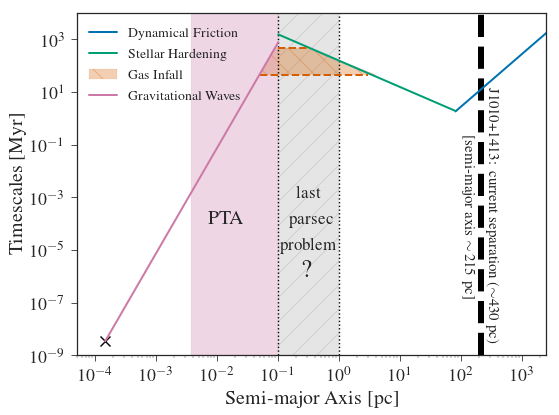

In [26]:
## Make the plot!
f, ax = plt.subplots(1,1, figsize=(8,6))

fsize = 20
tsize = 18

ax.tick_params(labelsize = tsize)
ax.axvline(a.value, c='black', linestyle='dashed', linewidth=6)
ax.axvline(1, c='black', linestyle='dotted')
ax.axvline(ahardsep.value, c='black', linestyle='dotted')
ax.axvspan(ahardsep.value,1., alpha=0.2, color='gray', hatch='/')


ax.loglog(plotadyn.value, plotdyntime.value, c=cs[0], linewidth=2,label='Dynamical Friction')
ax.loglog(plotahard.value, plothardtime.value, c=cs[1],linewidth=2, label='Stellar Hardening')
ax.loglog(plotagas.value, plotgastime.value, c=cs[2],linewidth=2, linestyle='dashed')
ax.fill([.05, .09, .3, 4],
         [plotgastime.value[0], plotgastime2.value[0], plotgastime2.value[0],plotgastime.value[0]],
         color=cs[2], alpha=0.3, hatch="\\",label='Gas Infall')
ax.loglog(plotagas2.value, plotgastime2.value, c=cs[2],linewidth=2, linestyle='dashed')

ax.loglog(plotagw.value, plotgwtime.value, c=cs[3],linewidth=2, label='Gravitational Waves')

ax.axvspan(ahardsep.value, gw_freq_to_pc(mtot_bh,pta_max,z).value, alpha=0.3,  color =cs[3]) #PTA band
ax.annotate('PTA', xy=(7.e-3, 1.e-4),fontsize=20) 
ax.text(255, 5,r'J1010+1413: current separation (${\sim} 430~\rm{pc}$)', rotation=-90, fontsize=15)
ax.text(105, 0.08,r'[semi-major axis $\sim 215~\rm{pc}$]', rotation=-90, fontsize=15)
ax.text(0.2, 1.e-3, 'last', fontsize=17)
ax.text(0.15, 1.e-4, 'parsec', fontsize=17)
ax.text(0.11, 1.e-5, 'problem', fontsize=17)
ax.text(0.25, 1.e-6, '?', fontsize=25)
ax.set_xlim([5.e-5, 2.5e3])
ax.set_ylim([1.e-9, 1.e4])

ax.scatter(amerge.value, mergetime.value, marker='x', color='black',s=100)
ax.set_xlabel('Semi-major Axis [pc]', fontsize=fsize)
ax.set_ylabel('Timescales [Myr]', fontsize=fsize)
handles, labels = ax.get_legend_handles_labels()
order = [0,1,3,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left',fontsize=14)

f.tight_layout()
plt.savefig('binary_lifestory.png', dpi=500)